# Levenshtein distance and spelling corrections
## Solution of https://github.com/apohllo/nlp/blob/master/3-levenshtein.md

In [1]:
from elasticsearch import Elasticsearch
from os import listdir
from os.path import isfile, join

In [2]:
es = Elasticsearch()

In [3]:
index = 'bill_index1'

In [4]:
def get_ids(directory_path):
    files = [file for file in listdir(directory_path) if isfile(join(directory_path, file))]
    ids = map(lambda file: f"{directory_path}/{file}",files)
    return list(ids)

In [5]:
ids = get_ids('./data/')

In [6]:
class Bill:
    def __init__ (self,id_, terms, term_freq_dict):
        self.id_ = id_
        self.terms= terms
        self.term_freq_dict = term_freq_dict
    def __repr__(self):
        return f"id: {self.id_},\nterms: {terms},\nterm frequency{self.term_freq_dict}\n"

In [7]:
def get_terms_data(term_vectors):
    return term_vectors['term_vectors']['content']['terms']

In [8]:
def get_terms(terms_data):
    return terms_data.keys()

In [9]:
def get_term_in_document(terms_data):
    doc_terms_dict = {}
    for term in terms_data:
        doc_terms_dict[term] = terms_data[term]['term_freq']
    return doc_terms_dict

In [10]:
bills = []

In [11]:
for id_ in ids:
    term_vectors = es.termvectors(index=index, doc_type='bill', id=id_, body= {
      "fields" : ["content"],
      "offsets" : True,
      "payloads" : True,
      "positions" : True,
      "term_statistics" : True,
      "field_statistics" : True
    })
    terms = get_terms_data(term_vectors)
    terms_in_doc = get_terms(terms)
    terms_freq = get_term_in_document(terms)
    bill = Bill(id_, terms_in_doc, terms_freq)
    bills.append(bill)

In [12]:
bills[:4]

[id: ./data//2003_2259.txt,
 terms: {'1': {'doc_freq': 1179, 'ttf': 74831, 'term_freq': 17, 'tokens': [{'position': 21, 'start_offset': 520, 'end_offset': 521}, {'position': 51, 'start_offset': 669, 'end_offset': 670}, {'position': 203, 'start_offset': 1615, 'end_offset': 1616}, {'position': 206, 'start_offset': 1623, 'end_offset': 1624}, {'position': 314, 'start_offset': 2620, 'end_offset': 2621}, {'position': 384, 'start_offset': 3176, 'end_offset': 3177}, {'position': 423, 'start_offset': 3456, 'end_offset': 3457}, {'position': 437, 'start_offset': 3526, 'end_offset': 3527}, {'position': 509, 'start_offset': 4045, 'end_offset': 4046}, {'position': 523, 'start_offset': 4112, 'end_offset': 4113}, {'position': 545, 'start_offset': 4242, 'end_offset': 4243}, {'position': 559, 'start_offset': 4326, 'end_offset': 4327}, {'position': 589, 'start_offset': 4540, 'end_offset': 4541}, {'position': 707, 'start_offset': 5661, 'end_offset': 5662}, {'position': 717, 'start_offset': 5712, 'end_offs

In [13]:
global_frequency = {}
global_frequency2 = {}

In [14]:
def get_global_term_frequency(terms_data):
    for term in terms_data:
        if term not in global_frequency:
            global_frequency[term] = terms_data[term]['ttf']

In [15]:
for id_ in ids:
    term_vectors = es.termvectors(index=index, doc_type='bill', id=id_, body= {
      "fields" : ["content"],
      "offsets" : True,
      "payloads" : True,
      "positions" : True,
      "term_statistics" : True,
      "field_statistics" : True
    })
    term_data = get_terms_data(term_vectors)
    get_global_term_frequency(term_data)

In [18]:
def get_global_term_frequency_from_bills():
    for bill in bills:
        term_freq_dict = bill.term_freq_dict
        for term in term_freq_dict:
            print(term)
            if term not in global_frequency2:
                global_frequency2[term] = term_freq_dict[term]
            else:
                term_count = global_frequency2[term] 
                term_count += term_freq_dict[term]

In [16]:
import regex as re

In [17]:
new_dict = {k: v for k, v in global_frequency.items() if  k.isalpha() and len(k) >= 2}

In [18]:
freuency = new_dict.items()

In [19]:
sorted_items = sorted(freuency, key=lambda entry: (-entry[1], entry[0]))

In [20]:
import numpy as np
from matplotlib import pyplot as plt

In [21]:
rankings = []
rank = 0
for k,v in sorted_items:
    rank += 1
    rankings += [(rank,k, v)]

In [22]:
ranking = np.array(rankings)

In [49]:
ranking

array([['1', 'wiek', '188681'],
       ['2', 'ojciec', '65253'],
       ['3', 'ocean', '65202'],
       ...,
       ['20554', 'акушерка', '1'],
       ['20555', 'медицинска', '1'],
       ['20556', 'сестра', '1']], dtype='<U65')

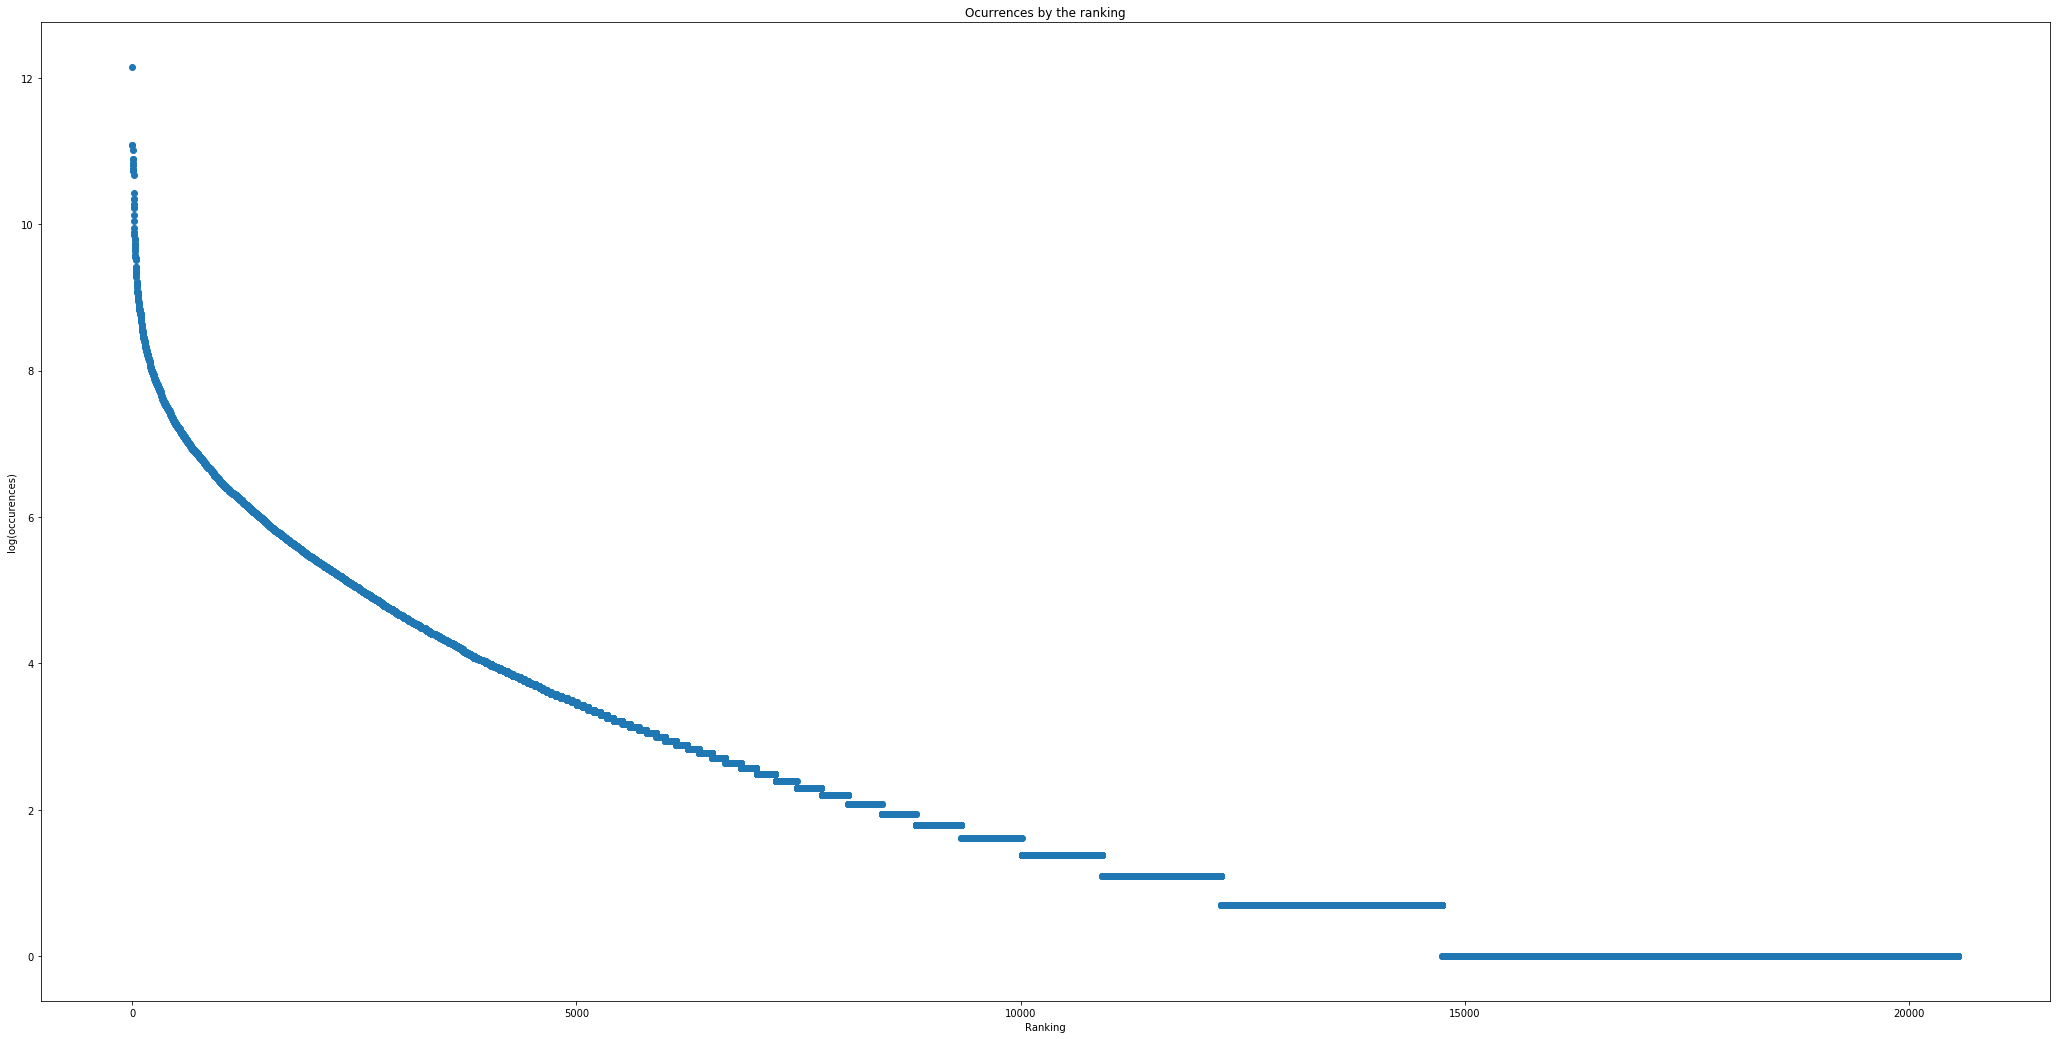

In [96]:
plt.figure(figsize=(36, 18))
plt.scatter(np.int16(ranking[:,0]),np.log(np.int64(ranking[:,2])))
plt.xlabel('Ranking')
plt.ylabel('log(occurences)')
plt.title('Ocurrences by the ranking')
plt.savefig('scatter.png', dpi=300)

# plt.xticks( d.keys(), d.values())
plt.show()

In [24]:

# data = pd.read_csv('./polimorfologik/polimorfologik-2.1.txt', sep=';', header = None)

In [24]:
import pandas as pd
import numpy as np

In [25]:
data = pd.read_csv('lower_dicttionary', sep=';', header = None)

In [26]:
words_in_dictionary =  np.array(data.iloc[:,0:2])

In [6]:
# word_lower = np.array([list(map(lambda x: x.lower(), row)) for row in words_in_dictionary ])

In [8]:
# with open('lower_dicttionary', 'w') as dest_file:
#     for word in word_lower:
#         dest_file.write(f"{word[0]};{word[1]}\n")

In [59]:
print('arta' in words_in_dictionary )

True


In [27]:
counter = 0
not_in_dictionary_top_30 = []
for (rank, word, occurences) in ranking:
    if word not in words_in_dictionary:
        not_in_dictionary_top_30.append((rank, word, occurences))
        counter+=1
    if(counter>30):
        break

In [28]:
not_in_dictionary_top_30

[('628', 'margin', '1111'),
 ('650', 'późn', '1080'),
 ('1166', 'family', '543'),
 ('1183', 'text', '531'),
 ('1330', 'mso', '448'),
 ('1447', 'bottom', '399'),
 ('1634', 'face', '327'),
 ('1645', 'panose', '326'),
 ('1652', 'serif', '325'),
 ('1739', 'gmo', '298'),
 ('1745', 'times', '296'),
 ('1840', 'iv', '272'),
 ('1868', 'sa', '266'),
 ('1918', 'name', '254'),
 ('1943', 'size', '248'),
 ('2016', 'left', '233'),
 ('2018', 'right', '233'),
 ('2050', 'sww', '227'),
 ('2235', 'skw', '196'),
 ('2408', 'ex', '169'),
 ('2416', 'height', '168'),
 ('2417', 'line', '168'),
 ('2463', 'ike', '162'),
 ('2537', 'vi', '154'),
 ('2831', 'indent', '121'),
 ('2846', 'remediacji', '120'),
 ('2957', 'vii', '111'),
 ('3057', 'ure', '103'),
 ('3137', 'uke', '97'),
 ('3165', 'kn', '95'),
 ('3355', 'cn', '83')]

In [28]:
# import pickle
# with open('not_top30.pickle', 'wb') as handle:
#     pickle.dump(not_in_dictionary_top_30, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
words_with_3 = list(filter(lambda x: int(x[2]) == 3, ranking))

In [30]:
not_in_dictionary_top_30_3_words = []
counter = 0
for (rank, word, occurences) in words_with_3:
    if word not in words_in_dictionary:
        not_in_dictionary_top_30_3_words.append((rank, word, occurences))
        counter+=1
    if(counter>30):
        break

In [29]:
import pickle
with open('three.pickle', 'rb') as handle:
    not_in_dictionary_top_30_3_words=  pickle.load(handle)

In [30]:
not_in_dictionary_top_30_3_words

[('10921', 'adaptacyjnoopiekuńcze', '3'),
 ('10924', 'agaricus', '3'),
 ('10951', 'apostille', '3'),
 ('10957', 'asistent', '3'),
 ('10961', 'auditorów', '3'),
 ('10963', 'autologicznego', '3'),
 ('10966', 'aw', '3'),
 ('10979', 'betaagonistycznym', '3'),
 ('10980', 'betania', '3'),
 ('10994', 'biorównoważności', '3'),
 ('11009', 'brucellosis', '3'),
 ('11024', 'cannabis', '3'),
 ('11025', 'caprine', '3'),
 ('11026', 'cattles', '3'),
 ('11027', 'cał', '3'),
 ('11031', 'cego', '3'),
 ('11035', 'chemiczn', '3'),
 ('11039', 'chloro', '3'),
 ('11044', 'cidr', '3'),
 ('11047', 'cobrpib', '3'),
 ('11050', 'condensed', '3'),
 ('11051', 'control', '3'),
 ('11054', 'cych', '3'),
 ('11055', 'cyjanamidowy', '3'),
 ('11058', 'cza', '3'),
 ('11070', 'daninowym', '3'),
 ('11073', 'deklarow', '3'),
 ('11082', 'dimocznika', '3'),
 ('11083', 'div', '3'),
 ('11084', 'dnego', '3'),
 ('11125', 'egzo', '3')]

In [40]:
# import pickle
# with open('three.pickle', 'wb') as handle:
#     pickle.dump(not_in_dictionary_top_30_3_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
dictionary_set =set(words_in_dictionary[:,0]).union(set(words_in_dictionary[:,1]))

In [67]:
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'aąbcćdeęfghijklłmnńoópqrsśtuvwxyzżź'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

In [68]:
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [69]:
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in dictionary_set)

In [70]:
def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

In [71]:
possible_correction = []

In [72]:
def get_corrections():
    for (rank, word, occurences) in not_in_dictionary_top_30_3_words:
        print(word)
        possible_correction.append((word,candidates(word)) )

In [92]:
def P(word, N=sum(new_dict.values())): 
    "Probability of `word`."
    if (word not in new_dict):
        return 0
    return new_dict[word] / N

In [93]:
def get_probabible_candidates(candidates):
    return sorted(list(map( lambda x: (x, P(x)), candidates)), key=lambda entry: (-entry[1], entry[0]))

In [95]:
for correction in possible_correction:
    print(f"{correction[0]}: {get_probabible_candidates(correction[1])}\n")

adaptacyjnoopiekuńcze: [('adaptacyjnoopiekuńcze', 7.123006003506893e-07)]

agaricus: [('agaricus', 7.123006003506893e-07)]

apostille: [('apostele', 0), ('apostilb', 0), ('apostilbem', 0), ('apostilbie', 0), ('apostilbu', 0), ('apostilby', 0), ('apostole', 0), ('postylle', 0)]

asistent: [('asystent', 8.547607204208271e-06)]

auditorów: [('audytorów', 0)]

autologicznego: [('antologicznego', 0), ('nautologicznego', 0), ('tautologicznego', 0)]

aw: [('aż', 2.208131861087137e-05), ('kw', 6.648138936606434e-06), ('mw', 6.648138936606434e-06), ('ów', 6.648138936606434e-06), ('ow', 3.7989365352036765e-06), ('jaw', 1.6620347341516084e-06), ('sw', 1.1871676672511488e-06), ('wa', 9.497341338009191e-07), ('aa', 4.7486706690045956e-07), ('ad', 4.7486706690045956e-07), ('ar', 4.7486706690045956e-07), ('at', 4.7486706690045956e-07), ('ac', 2.3743353345022978e-07), ('au', 2.3743353345022978e-07), ('uw', 2.3743353345022978e-07), ('żw', 2.3743353345022978e-07), ('a', 0), ('adw', 0), ('af', 0), ('ag',